## Install Libraries

In [ ]:
#!pip install langchain openai faiss-cpu datasets sentence_transformers langchain-community tiktoken langchain-openai gradio

## Import necessary libraries

In [ ]:
# Import necessary libraries
import os
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from datasets import load_dataset
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.llms import HuggingFaceHub
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Suppress warnings
logging.getLogger("langchain.text_splitter").setLevel(logging.ERROR)


## Load and Preprocess SQuAD Dataset

In [ ]:
# Load SQuAD dataset
dataset = load_dataset('squad')

# Extract contexts from the training split
contexts = [item['context'] for item in dataset['train']]

# Remove duplicate contexts
contexts = list(set(contexts))

print(f"Total unique contexts: {len(contexts)}")


Total unique contexts: 18891


## Split Contexts into Chunks

In [ ]:
# Initialize the RecursiveCharacterTextSplitter
chunk_size_limit = 500  # Define the chunk size limit

text_splitter = RecursiveCharacterTextSplitter(
    separators=["\n\n", "\n", " ", ""],
    chunk_size=chunk_size_limit,
    chunk_overlap=100,
    length_function=len,
)

# Split the texts and collect data for visualization
chunk_sizes = []
chunks_per_context = []
documents = []
total_chunks = 0

for idx, context in enumerate(contexts):
    splits = text_splitter.split_text(context)
    num_splits = len(splits)
    chunks_per_context.append(num_splits)
    total_chunks += num_splits
    print(f"Context {idx + 1}/{len(contexts)}: Split into {num_splits} chunks.")

    for i, split in enumerate(splits):
        chunk_size = len(split)
        chunk_sizes.append(chunk_size)
        print(f" - Chunk {i + 1}/{num_splits}: {chunk_size} characters")
        if chunk_size > chunk_size_limit:
            print(f"   WARNING: Chunk size {chunk_size} exceeds the specified chunk_size {chunk_size_limit}.")
        documents.append(Document(page_content=split))

print(f"\nTotal documents created: {total_chunks}")


Streaming output truncated to the last 5000 lines.
 - Chunk 1/2: 491 characters
 - Chunk 2/2: 120 characters
Context 17317/18891: Split into 2 chunks.
 - Chunk 1/2: 495 characters
 - Chunk 2/2: 325 characters
Context 17318/18891: Split into 3 chunks.
 - Chunk 1/3: 499 characters
 - Chunk 2/3: 496 characters
 - Chunk 3/3: 129 characters
Context 17319/18891: Split into 2 chunks.
 - Chunk 1/2: 497 characters
 - Chunk 2/2: 133 characters
Context 17320/18891: Split into 4 chunks.
 - Chunk 1/4: 496 characters
 - Chunk 2/4: 492 characters
 - Chunk 3/4: 498 characters
 - Chunk 4/4: 156 characters
Context 17321/18891: Split into 5 chunks.
 - Chunk 1/5: 496 characters
 - Chunk 2/5: 495 characters
 - Chunk 3/5: 499 characters
 - Chunk 4/5: 499 characters
 - Chunk 5/5: 255 characters
Context 17322/18891: Split into 1 chunks.
 - Chunk 1/1: 384 characters
Context 17323/18891: Split into 2 chunks.
 - Chunk 1/2: 490 characters
 - Chunk 2/2: 172 characters
Context 17324/18891: Split into 1 chunks.
 - C

## Visualize Chunked Documents

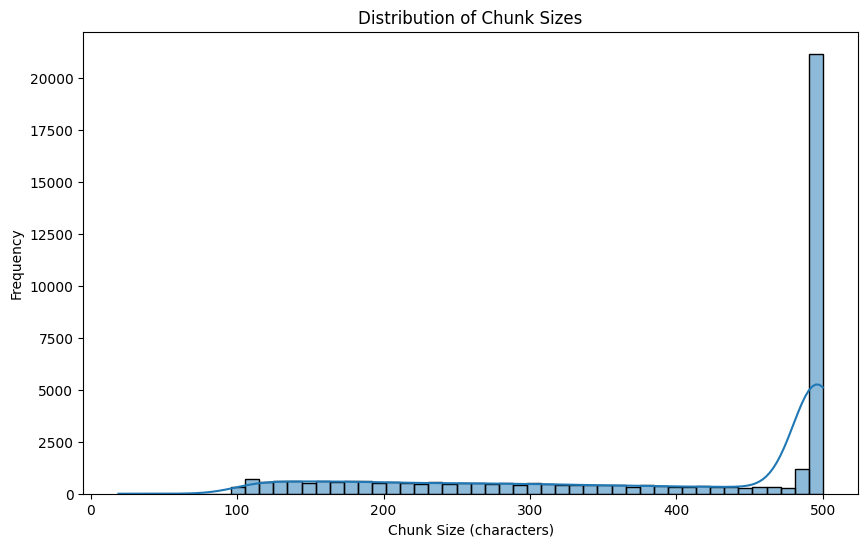

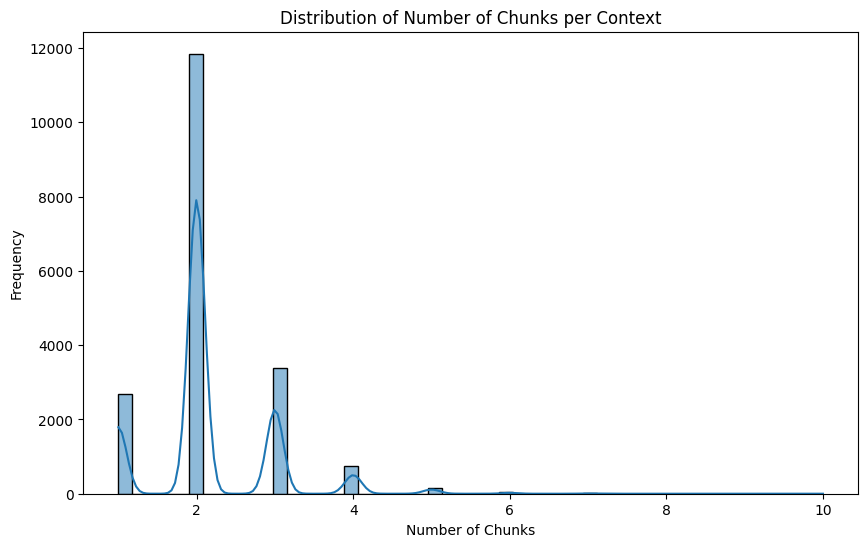

In [ ]:
# Visualization 1: Chunk Size Distribution
plt.figure(figsize=(10, 6))
sns.histplot(chunk_sizes, bins=50, kde=True)
plt.title('Distribution of Chunk Sizes')
plt.xlabel('Chunk Size (characters)')
plt.ylabel('Frequency')
plt.show()

# Visualization 2: Chunks per Context
plt.figure(figsize=(10, 6))
sns.histplot(chunks_per_context, bins=50, kde=True)
plt.title('Distribution of Number of Chunks per Context')
plt.xlabel('Number of Chunks')
plt.ylabel('Frequency')
plt.show()


## Create Embeddings for the Documents (OpenAI Embeddings)

In [ ]:
import openai
import getpass

openai.api_key = getpass.getpass("Please enter your OpenAI API key: ")


Please enter your OpenAI API key: ··········


In [ ]:
from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key)

# Generate embeddings for the documents
texts = [doc.page_content for doc in documents]

print("Generating embeddings for documents...")
embeddings_list = embeddings.embed_documents(texts)
print("Embeddings generated.")


<ipython-input-10-4d16069f4bcf>:3: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embeddings = OpenAIEmbeddings(openai_api_key=openai.api_key)


Generating embeddings for documents...
Embeddings generated.


## Visualize Document Embeddings

Performing PCA...
PCA completed.
Performing t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40727 samples in 0.005s...


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computed neighbors for 40727 samples in 2.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40727
[t-SNE] Computed conditional probabilities for sample 2000 / 40727
[t-SNE] Computed conditional probabilities for sample 3000 / 40727
[t-SNE] Computed conditional probabilities for sample 4000 / 40727
[t-SNE] Computed conditional probabilities for sample 5000 / 40727
[t-SNE] Computed conditional probabilities for sample 6000 / 40727
[t-SNE] Computed conditional probabilities for sample 7000 / 40727
[t-SNE] Computed conditional probabilities for sample 8000 / 40727
[t-SNE] Computed conditional probabilities for sample 9000 / 40727
[t-SNE] Computed conditional probabilities for sample 10000 / 40727
[t-SNE] Computed conditional probabilities for sample 11000 / 40727
[t-SNE] Computed conditional probabilities for sample 12000 / 40727
[t-SNE] Computed conditional probabilities for sample 13000 / 40727
[t-SNE] Computed conditional probabilities for sample 14000 / 40727

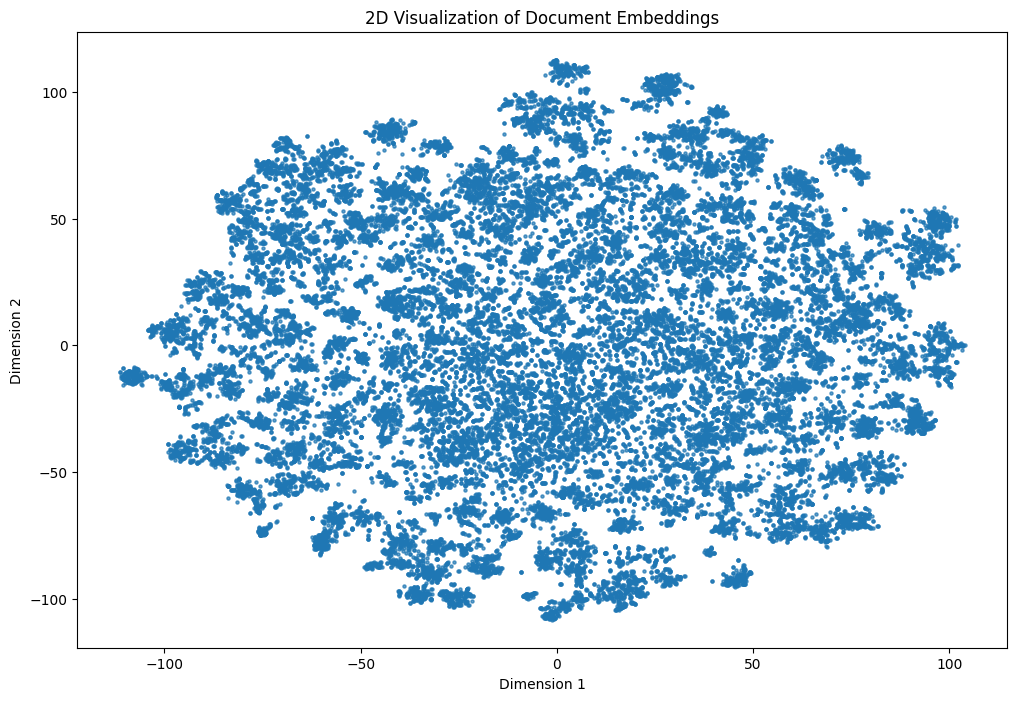

In [ ]:
# Convert embeddings to numpy array
embeddings_array = np.array(embeddings_list)

# Reduce dimensions to 50 using PCA for t-SNE efficiency
print("Performing PCA...")
pca = PCA(n_components=50)
embeddings_pca = pca.fit_transform(embeddings_array)
print("PCA completed.")

# Further reduce to 2D using t-SNE
print("Performing t-SNE...")
tsne = TSNE(n_components=2, perplexity=30, verbose=1, n_iter=1000)
embeddings_2d = tsne.fit_transform(embeddings_pca)
print("t-SNE completed.")

# Plot the embeddings
plt.figure(figsize=(12, 8))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], s=5, alpha=0.7)
plt.title('2D Visualization of Document Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()


## Create the Vector Store

In [ ]:
from langchain.vectorstores import FAISS

vectorstore = FAISS.from_documents(documents, embeddings)


In [ ]:
vectorstore.search(query="What is photosynthesis?", k=2, search_type="similarity")

[Document(metadata={}, page_content='The study of plants is vital because they underpin almost all animal life on Earth by generating a large proportion of the oxygen and food that provide humans and other organisms with aerobic respiration with the chemical energy they need to exist. Plants, algae and cyanobacteria are the major groups of organisms that carry out photosynthesis, a process that uses the energy of sunlight to convert water and carbon dioxide into sugars that can be used both as a source of chemical energy and of'),
 Document(metadata={}, page_content='Plant physiology encompasses all the internal chemical and physical activities of plants associated with life. Chemicals obtained from the air, soil and water form the basis of all plant metabolism. The energy of sunlight, captured by oxygenic photosynthesis and released by cellular respiration, is the basis of almost all life. Photoautotrophs, including all green plants, algae and cyanobacteria gather energy directly from

## Integrate with LangChain and Create the RAG Pipeline

```
# Set up the retriever
#retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

# Initialize the language model using HuggingFaceHub
# Note: You'll need a Hugging Face API token set as HUGGINGFACEHUB_API_TOKEN
# You can obtain one from https://huggingface.co/settings/tokens
#os.environ["HUGGINGFACEHUB_API_TOKEN"] = 'your-huggingface-api-token-here'

#llm = HuggingFaceHub(repo_id="google/flan-t5-base", model_kwargs={"temperature": 0})

# Create the conversational retrieval chain
#qa_chain = ConversationalRetrievalChain.from_llm(llm, retriever)
```

**Set up the Retriever**

In [ ]:
# Set up the retriever
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

**Initialize the Language Model**

In [ ]:
from langchain_openai import OpenAI

llm = OpenAI(temperature=0, openai_api_key=openai.api_key)


**Create Conversational Retrieval Chain**

In [ ]:
from langchain.chains import ConversationalRetrievalChain

qa_chain = ConversationalRetrievalChain.from_llm(llm, retriever)


## Implement Multi-turn Conversational Memory

**Initialize Chat History**

In [33]:
chat_history = []


## Build the Chatbot Interface with Visualizations

In [93]:
def get_query_embedding(query):
    return embeddings.embed_query(query)

def plot_query_and_docs(query):
    query_embedding = get_query_embedding(query)
    combined_embeddings = np.vstack([embeddings_pca, pca.transform([query_embedding])])
    embeddings_2d_all = tsne.fit_transform(combined_embeddings)
    doc_embeddings_2d = embeddings_2d_all[:-1]
    query_embedding_2d = embeddings_2d_all[-1]

    plt.figure(figsize=(12, 8))
    plt.scatter(doc_embeddings_2d[:, 0], doc_embeddings_2d[:, 1], alpha=0.5, label='Documents')
    plt.scatter(query_embedding_2d[0], query_embedding_2d[1], color='red', label='Query')
    plt.title('Query and Document Embeddings in 2D Space')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

def plot_similarity_scores_with_highlights(query, top_k=5):
    query_embedding = get_query_embedding(query)
    scores = cosine_similarity([query_embedding], embeddings_array)[0]
    sorted_indices = np.argsort(scores)[::-1]
    top_indices = sorted_indices[:top_k]

    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(scores)), scores)
    for i in top_indices:
        bars[i].set_color('red')
    plt.title('Similarity Scores between Query and Documents')
    plt.xlabel('Document Index')
    plt.ylabel('Cosine Similarity')
    plt.show()

def display_retrieved_docs(query):
    docs_with_scores = vectorstore.similarity_search_with_score(query, k=5)
    for i, (doc, score) in enumerate(docs_with_scores):
        print(f"Document {i+1} (Score: {score:.4f}):")
        print(doc.page_content[:500])  # Display the first 500 characters
        print('-' * 80)




**Implement the Chat Loop**

Interaction:
```
User: What is the capital of France?
Bot:  Paris
User: What is its population?
Bot:  The population of Paris is 2,241,346 in its administrative city limits as of January 2014. However, the entire Paris agglomeration has a population of 10,550,350 and the Paris metropolitan area has a population of 12,341,418 as of the January 2012 census.
User: What language is spoken there?
Bot:
French
User: What is the best time to plan for a holiday visit?
Bot:  The best time to plan for a holiday visit to Paris would be during the Paris Fashion Week in January or July, as well as during the summer months when the weather is pleasant and there are many cultural events and festivals happening in the city.
User: How to get there from San Diego?
Bot:  You can travel from San Diego to Paris by taking a flight from San Diego International Airport to Paris Charles de Gaulle Airport. Alternatively, you can take a train from San Diego to Los Angeles and then transfer to a flight to Paris.
User: exit
Goodbye!
```


User: What is the capital of France?
Bot:  The capital of France is Paris.


/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 40728 samples in 0.002s...
[t-SNE] Computed neighbors for 40728 samples in 2.302s...
[t-SNE] Computed conditional probabilities for sample 1000 / 40728
[t-SNE] Computed conditional probabilities for sample 2000 / 40728
[t-SNE] Computed conditional probabilities for sample 3000 / 40728
[t-SNE] Computed conditional probabilities for sample 4000 / 40728
[t-SNE] Computed conditional probabilities for sample 5000 / 40728
[t-SNE] Computed conditional probabilities for sample 6000 / 40728
[t-SNE] Computed conditional probabilities for sample 7000 / 40728
[t-SNE] Computed conditional probabilities for sample 8000 / 40728
[t-SNE] Computed conditional probabilities for sample 9000 / 40728
[t-SNE] Computed conditional probabilities for sample 10000 / 40728
[t-SNE] Computed conditional probabilities for sample 11000 / 40728
[t-SNE] Computed conditional probabilities for sample 12000 / 40728
[t-SNE] Computed conditional probabilities for sam

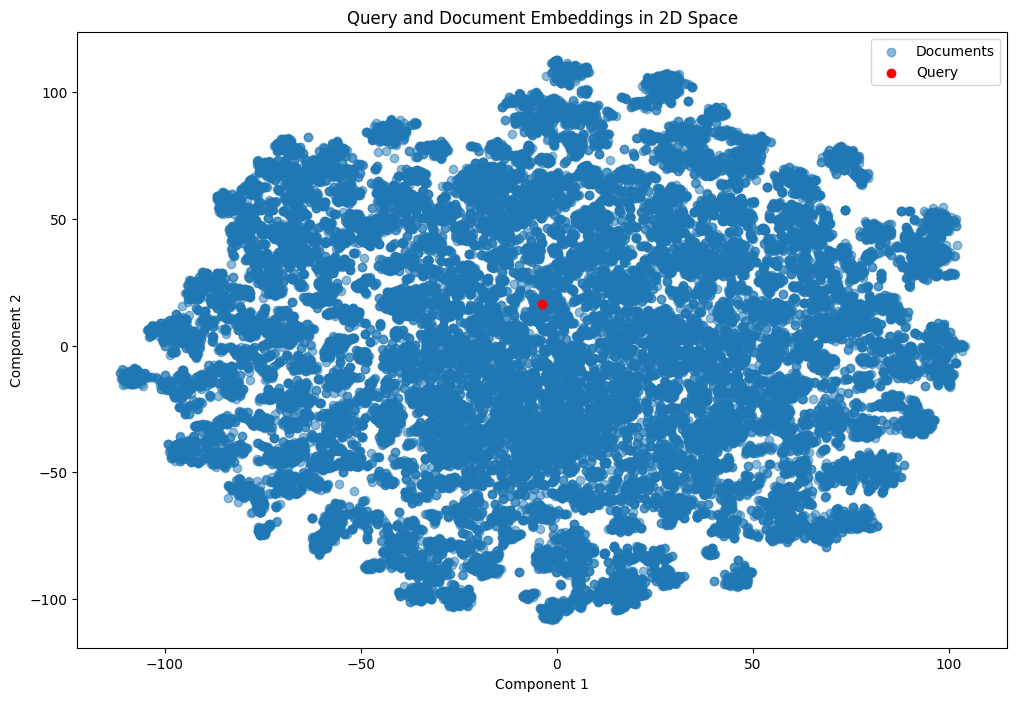

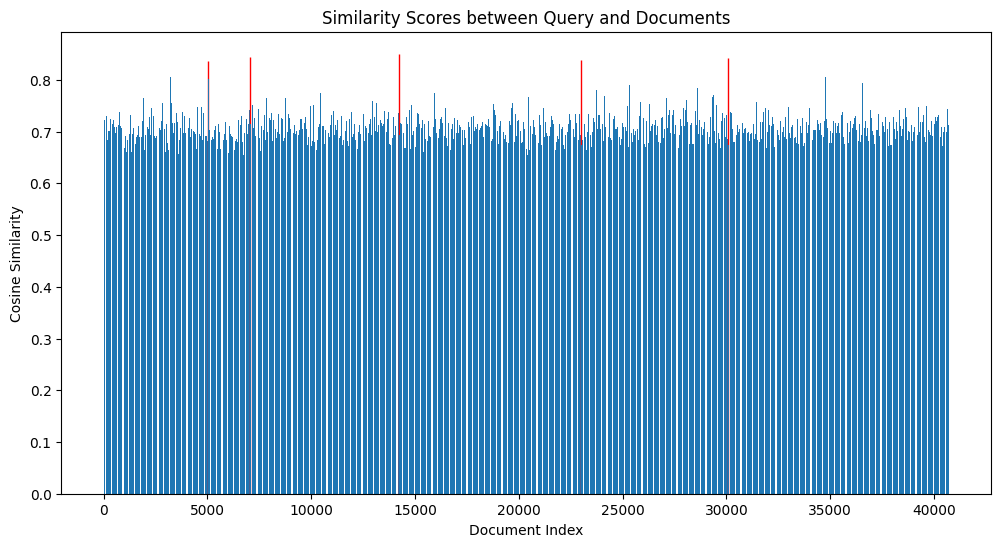

Document 1 (Score: 0.2988):
of Sacré-Cœur on Montmartre (1914). In 2014 Paris received 22.4 million visitors, making it one of the world's top tourist destinations. Paris is also known for its fashion, particularly the twice-yearly Paris Fashion Week, and for its haute cuisine, and three-star restaurants. Most of France's major universities and grandes écoles are located in Paris, as are France's major newspapers, including Le Monde, Le Figaro, and Libération.
--------------------------------------------------------------------------------
Document 2 (Score: 0.3112):
In 2015 it hosts the world headquarters of 29 of the 31 Fortune Global 500 companies located in France.
--------------------------------------------------------------------------------
Document 3 (Score: 0.3136):
Clovis the Frank, the first king of the Merovingian dynasty, made the city his capital from 508. A gradual immigration by the Franks also occurred in Paris in the beginning of the Frankish domination of Gaul which

In [94]:
while True:
    question = input("User: ")
    if question.lower() in ["exit", "quit"]:
        print("Goodbye!")
        break

    # Get the answer from the chain
    result = qa_chain({"question": question, "chat_history": chat_history})
    answer = result["answer"]
    print(f"Bot: {answer}")
    chat_history.append((question, answer))

    # Display visualizations
    plot_query_and_docs(question)
    plot_similarity_scores_with_highlights(question)
    display_retrieved_docs(question)



In [51]:
import gradio as gr
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import logging

# Set up logging for debugging
logging.basicConfig(level=logging.DEBUG)

chat_history = []  # Global chat history to preserve between requests

# Debugging log for chatbot interaction
def chat_with_bot(question, history):
    logging.debug(f"Received question: {question}")
    try:
        # Get the answer from the chain
        result = qa_chain({"question": question, "chat_history": history})
        answer = result["answer"]
        logging.debug(f"Generated answer: {answer}")

        # Update history with the new question-answer pair
        history.append((question, answer))

        # Display visualizations (integrate these into the Gradio UI)
        query_docs_plot_path = plot_query_and_docs(question)
        similarity_scores_plot_path = plot_similarity_scores_with_highlights(question)

        # Display retrieved documents (for simplicity, we return them as text here)
        retrieved_docs = []
        docs_with_scores = vectorstore.similarity_search_with_score(question, k=5)
        for i, (doc, score) in enumerate(docs_with_scores):
            retrieved_docs.append(f"Document {i+1} (Score: {score:.4f}): {doc.page_content[:200]}")

        logging.debug(f"Retrieved documents: {retrieved_docs}")
        return history, retrieved_docs, query_docs_plot_path, similarity_scores_plot_path
    except Exception as e:
        logging.error(f"Error in chat_with_bot: {str(e)}")
        return history, ["Error occurred, check logs for details."], None, None

# Visualization functions with logs
def plot_query_and_docs(query):
    logging.debug("Generating Query and Document Embeddings plot.")
    try:
        query_embedding = get_query_embedding(query)
        combined_embeddings = np.vstack([embeddings_pca, pca.transform([query_embedding])])
        embeddings_2d_all = tsne.fit_transform(combined_embeddings)
        doc_embeddings_2d = embeddings_2d_all[:-1]
        query_embedding_2d = embeddings_2d_all[-1]

        plt.figure(figsize=(12, 8))
        plt.scatter(doc_embeddings_2d[:, 0], doc_embeddings_2d[:, 1], alpha=0.5, label='Documents')
        plt.scatter(query_embedding_2d[0], query_embedding_2d[1], color='red', label='Query')
        plt.title('Query and Document Embeddings in 2D Space')
        plt.xlabel('Component 1')
        plt.ylabel('Component 2')
        plt.legend()
        plt.savefig('query_docs.png')
        plt.close()
        logging.debug("Query and Document Embeddings plot generated.")
        return 'query_docs.png'
    except Exception as e:
        logging.error(f"Error in plot_query_and_docs: {str(e)}")
        return None

def plot_similarity_scores_with_highlights(query, top_k=5):
    logging.debug("Generating Similarity Scores plot.")
    try:
        query_embedding = get_query_embedding(query)
        scores = cosine_similarity([query_embedding], embeddings_array)[0]
        sorted_indices = np.argsort(scores)[::-1]
        top_indices = sorted_indices[:top_k]

        plt.figure(figsize=(12, 6))
        bars = plt.bar(range(len(scores)), scores)
        for i in top_indices:
            bars[i].set_color('red')
        plt.title('Similarity Scores between Query and Documents')
        plt.xlabel('Document Index')
        plt.ylabel('Cosine Similarity')
        plt.savefig('similarity_scores.png')
        plt.close()
        logging.debug("Similarity Scores plot generated.")
        return 'similarity_scores.png'
    except Exception as e:
        logging.error(f"Error in plot_similarity_scores_with_highlights: {str(e)}")
        return None

# Build Gradio UI with layouts for full-height chatbot and scrollable similarity/doc embeddings
def create_gradio_interface():
    logging.debug("Building Gradio interface.")
    try:
        with gr.Blocks(css="""
            #chatbot_container {
                height: 100vh;
                display: flex;
                flex-direction: column;
            }
            #chatbot {
                flex-grow: 1;
                overflow-y: scroll;
            }
            #send_button {
                width: 150px;
                height: 40px;
                font-size: 16px;
            }
            .scrollable-area {
                max-height: 400px;
                overflow-y: scroll;
            }
            #textbox {
                width: 85%;
            }
        """) as demo:
            with gr.Row():
                # Left side: Chatbot that takes full height and conversation scrolls
                with gr.Column(scale=3, elem_id="chatbot_container"):
                    chatbot = gr.Chatbot(elem_id="chatbot")
                    # Text input takes 85%, button takes 15%
                    with gr.Row():
                        textbox = gr.Textbox(show_label=False, placeholder="Type your message here...", lines=1, elem_id="textbox")
                        submit_btn = gr.Button("Send", elem_id="send_button")  # Send button with custom width

                # Right side: Retrieved docs, similarity scores, and query-document embeddings
                with gr.Column(scale=1):
                    doc_display = gr.Textbox(label="Top Retrieved Documents", interactive=False, elem_classes="scrollable-area")
                    query_doc_plot = gr.Image(label="Query and Document Embeddings", elem_classes="scrollable-area")
                    similarity_plot = gr.Image(label="Similarity Scores", elem_classes="scrollable-area")

            def handle_input(user_input, history):
                logging.debug(f"Handling input: {user_input}")
                updated_history, retrieved_docs, query_plot, similarity_plot = chat_with_bot(user_input, history)
                return updated_history, retrieved_docs, query_plot, similarity_plot, gr.update(value="")  # Clear textbox

            # After sending the message, clear the textbox by using gr.update(value="")
            submit_btn.click(handle_input, [textbox, chatbot], [chatbot, doc_display, query_doc_plot, similarity_plot, textbox], queue=True)

        logging.debug("Gradio interface built successfully.")
        return demo
    except Exception as e:
        logging.error(f"Error in create_gradio_interface: {str(e)}")
        return None

# Launch Gradio interface
demo = create_gradio_interface()
if demo:
    demo.launch()
else:
    logging.error("Gradio interface failed to launch.")


/usr/local/lib/python3.10/dist-packages/gradio/components/chatbot.py:222: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://92ab9a125a6405145e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


```
User: What is the capital of France?
Bot:  Paris
User: What is its population?
Bot:  The population of Paris is 2,241,346 in its administrative city limits as of January 2014. However, the entire Paris agglomeration has a population of 10,550,350 and the Paris metropolitan area has a population of 12,341,418 as of the January 2012 census.
User: What language is spoken there?
Bot:
French
User: What is the best time to plan for a holiday visit?
Bot:  The best time to plan for a holiday visit to Paris would be during the Paris Fashion Week in January or July, as well as during the summer months when the weather is pleasant and there are many cultural events and festivals happening in the city.
User: How to get there from San Diego?
Bot:  You can travel from San Diego to Paris by taking a flight from San Diego International Airport to Paris Charles de Gaulle Airport. Alternatively, you can take a train from San Diego to Los Angeles and then transfer to a flight to Paris.
User: exit
Goodbye!
```